In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
import os

In [23]:
#device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
#set up seed for consistancy
torch.manual_seed(1)
#hyperparameters
learning_rate = 5e-5
batch_size = 64
image_size = 64
#black and white 1 for color img 3(r.g.b)
image_channels = 3
z_dimension = 128
epochs = 5
discriminator_features = 64
generator_features = 64
discriminator_iterations = 5
weight = 0.01
#get Cifar10 dataset
transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(image_channels)], [0.5 for _ in range(image_channels)]
        ),
    ]
)
data_train = torchvision.datasets.CIFAR10(root='./DL HW 3/data', 
                                           train=True, 
                                           transform=transforms,  
                                           download=True)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                          shuffle=True)

Files already downloaded and verified


In [25]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.discrim = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._descrimStructure(features_d, features_d * 2, 4, 2, 1),
            self._descrimStructure(features_d * 2, features_d * 4, 4, 2, 1),
            self._descrimStructure(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _descrimStructure(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.discrim(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.genet = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._genetStructure(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._genetStructure(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._genetStructure(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._genetStructure(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _genetStructure(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.genet(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [26]:
genet = Generator(z_dimension, image_channels, generator_features).to(device)
critic = Discriminator(image_channels, discriminator_features).to(device)
initialize_weights(genet)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.RMSprop(genet.parameters(), lr=learning_rate)
opt_critic = optim.RMSprop(critic.parameters(), lr=learning_rate)

# for tensorboard plotting
fixed_noise = torch.randn(10, z_dimension, 1, 1).to(device)
step = 0
loss_ge = []
loss_de = []
genet.train()
critic.train()
fakeimg_list=[]
img_list=[]

# Create directory to save generated images
output_dir = "WGAN_output"
os.makedirs(output_dir, exist_ok=True)

for epoch in range(epochs):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        cur_batch_size = data.shape[0]
        # Save generated images to file
        if batch_idx % 100 == 0 and batch_idx > 0:
            genet.eval()
            critic.eval()
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                fak = genet(fixed_noise).detach().cpu()
                realI = data.detach().cpu()
                torchvision.utils.save_image(fak, os.path.join(output_dir, f"generated_{epoch}_{batch_idx}.png"))
                torchvision.utils.save_image(realI, os.path.join(output_dir, f"real_{epoch}_{batch_idx}.png"))
            step += 1
            genet.train()
            critic.train()

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(discriminator_iterations):
            noise = torch.randn(cur_batch_size, z_dimension, 1, 1).to(device)
            fake = genet(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()

            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            # clip critic weights between -0.01, 0.01
            for p in critic.parameters():
                p.data.clamp_(-weight, weight)

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)

        genet.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        loss_de.append(loss_critic.detach().cpu())
        loss_ge.append(loss_gen.detach().cpu())
        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            genet.eval()
            critic.eval()
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fak = genet(fixed_noise).detach().cpu()
                realI = data.detach().cpu()
                fakeimg_list.append(torchvision.utils.make_grid(fak, padding=2, normalize=True))
                img_list.append(torchvision.utils.make_grid(realI, padding=2, normalize=True))
            step += 1
            genet.train()
            critic.train()

# Print saved images file paths
# Print saved images file paths
print("Generated images saved to:", os.path.join(output_dir, "generated_*.png"))
print("Contents of fakeimg_list:", fakeimg_list)
print("Contents of loss_de:", loss_de)
print("Contents of loss_ge:", loss_ge)


Epoch [0/5] Batch 100/782                   Loss D: -1.3587, loss G: 0.6674
Epoch [0/5] Batch 100/782                   Loss D: -1.3658, loss G: 0.6697
Epoch [0/5] Batch 200/782                   Loss D: -1.5203, loss G: 0.7452
Epoch [0/5] Batch 200/782                   Loss D: -1.5060, loss G: 0.7355
Epoch [0/5] Batch 300/782                   Loss D: -1.5150, loss G: 0.7438
Epoch [0/5] Batch 300/782                   Loss D: -1.4990, loss G: 0.7360
Epoch [0/5] Batch 400/782                   Loss D: -1.5235, loss G: 0.7481
Epoch [0/5] Batch 400/782                   Loss D: -1.4869, loss G: 0.7330
Epoch [0/5] Batch 500/782                   Loss D: -1.4459, loss G: 0.7210
Epoch [0/5] Batch 500/782                   Loss D: -1.4647, loss G: 0.7265
Epoch [0/5] Batch 600/782                   Loss D: -1.4849, loss G: 0.7329
Epoch [0/5] Batch 600/782                   Loss D: -1.4863, loss G: 0.7282
Epoch [0/5] Batch 700/782                   Loss D: -1.3812, loss G: 0.6932
Epoch [0/5] 

Contents of loss_de: [tensor(-0.0179), tensor(-0.0239), tensor(-0.0285), tensor(-0.0345), tensor(-0.0378), tensor(-0.0439), tensor(-0.0511), tensor(-0.0550), tensor(-0.0676), tensor(-0.0722), tensor(-0.0829), tensor(-0.0956), tensor(-0.1096), tensor(-0.1227), tensor(-0.1369), tensor(-0.1637), tensor(-0.1760), tensor(-0.1977), tensor(-0.2185), tensor(-0.2389), tensor(-0.2785), tensor(-0.3044), tensor(-0.3278), tensor(-0.3538), tensor(-0.3865), tensor(-0.4175), tensor(-0.4483), tensor(-0.4835), tensor(-0.5170), tensor(-0.5425), tensor(-0.5655), tensor(-0.5926), tensor(-0.6190), tensor(-0.6419), tensor(-0.6674), tensor(-0.6919), tensor(-0.7170), tensor(-0.7295), tensor(-0.7541), tensor(-0.7592), tensor(-0.7888), tensor(-0.8062), tensor(-0.8258), tensor(-0.8266), tensor(-0.8496), tensor(-0.8385), tensor(-0.8745), tensor(-0.8711), tensor(-0.8979), tensor(-0.8986), tensor(-0.9264), tensor(-0.9310), tensor(-0.9343), tensor(-0.9677), tensor(-0.9791), tensor(-0.9812), tensor(-0.9958), tensor(-0

Contents of loss_ge: [tensor(0.0021), tensor(0.0061), tensor(0.0093), tensor(0.0123), tensor(0.0156), tensor(0.0196), tensor(0.0241), tensor(0.0290), tensor(0.0349), tensor(0.0419), tensor(0.0495), tensor(0.0582), tensor(0.0676), tensor(0.0783), tensor(0.0893), tensor(0.1013), tensor(0.1140), tensor(0.1268), tensor(0.1398), tensor(0.1528), tensor(0.1663), tensor(0.1800), tensor(0.1926), tensor(0.2056), tensor(0.2182), tensor(0.2300), tensor(0.2416), tensor(0.2549), tensor(0.2664), tensor(0.2789), tensor(0.2879), tensor(0.3006), tensor(0.3104), tensor(0.3209), tensor(0.3295), tensor(0.3422), tensor(0.3520), tensor(0.3586), tensor(0.3678), tensor(0.3746), tensor(0.3839), tensor(0.3931), tensor(0.4001), tensor(0.4049), tensor(0.4122), tensor(0.4114), tensor(0.4229), tensor(0.4253), tensor(0.4332), tensor(0.4370), tensor(0.4484), tensor(0.4524), tensor(0.4531), tensor(0.4704), tensor(0.4725), tensor(0.4763), tensor(0.4839), tensor(0.4849), tensor(0.4975), tensor(0.5015), tensor(0.5006), te

In [ ]:
print("Contents of fakeimg_list:", fakeimg_list)
print("Contents of loss_de:", loss_de)
print("Contents of loss_ge:", loss_ge

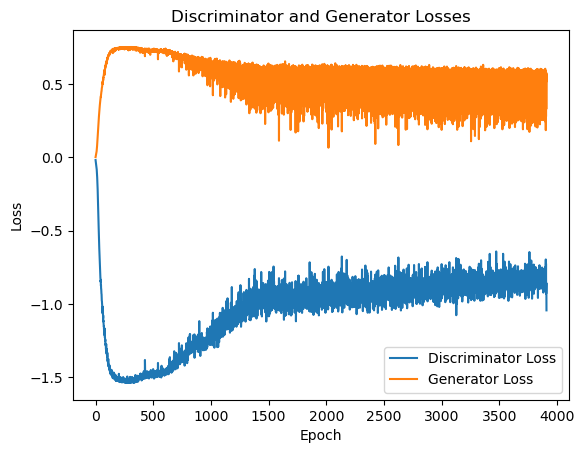

In [31]:
import matplotlib.pyplot as plt

# Losses plot
plt.plot(loss_de, label='Discriminator Loss')
plt.plot(loss_ge, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator and Generator Losses')
plt.show()


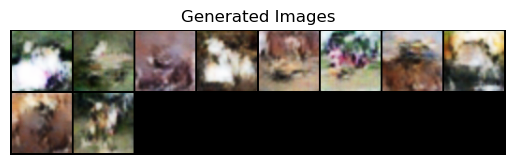

In [32]:
import torchvision.utils as vutils

# Generated images plot
fakeimg_grid = vutils.make_grid(fakeimg_list[-1], padding=2, normalize=True)
plt.imshow(fakeimg_grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Generated Images')
plt.show()


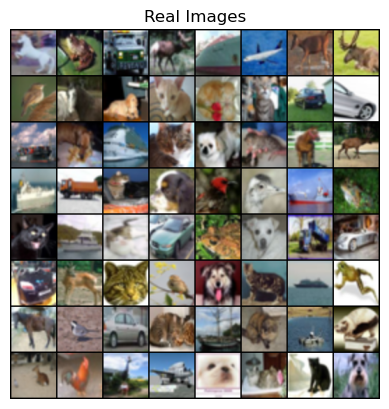

In [33]:
# Real images plot
realimg_grid = vutils.make_grid(img_list[-1], padding=2, normalize=True)
plt.imshow(realimg_grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Real Images')
plt.show()


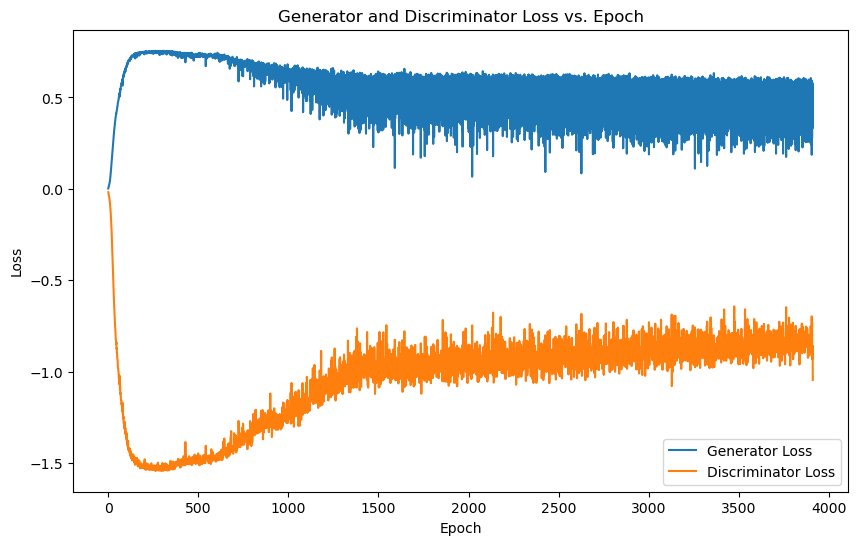

In [34]:
import matplotlib.pyplot as plt

# Plot generator and discriminator loss vs. epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_ge) + 1), loss_ge, label='Generator Loss')
plt.plot(range(1, len(loss_de) + 1), loss_de, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss vs. Epoch')
plt.legend()
plt.show()


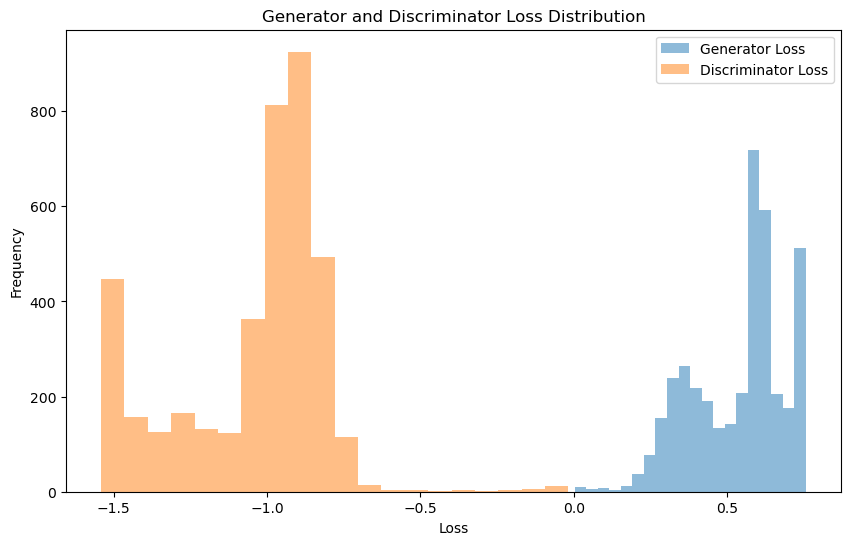

In [35]:
import matplotlib.pyplot as plt

# Plot histogram of generator and discriminator loss
plt.figure(figsize=(10, 6))
plt.hist(loss_ge, bins=20, alpha=0.5, label='Generator Loss')
plt.hist(loss_de, bins=20, alpha=0.5, label='Discriminator Loss')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Generator and Discriminator Loss Distribution')
plt.legend()
plt.show()


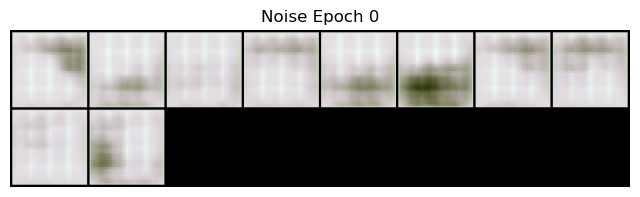

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Noise Epoch 0')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeimg_list[0:1]]


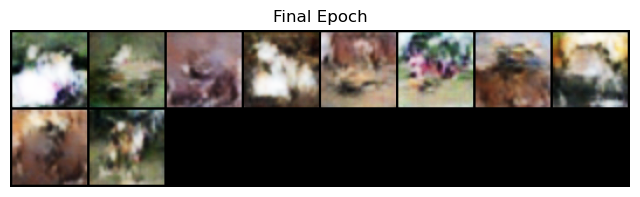

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Final Epoch')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeimg_list]